In [ ]:
import os 
import json
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
import plotly.io as pio
import seaborn as sns

from cmcrameri import cm
from glob import glob
from datetime import datetime
from pandas import concat, DataFrame, read_csv
from numpy import arange
from IPython.display import HTML

import functions as ft

sns.set_style('white')

# Introduction

ToDo
- describe workflow
- average(?) same classes that are layered together

# User Input

In [12]:
user_input_address = "Depot Boijmans Van Beuningen"

# Settings

In [2]:
url = "https://service.pdok.nl/cbs/gebiedsindelingen/2025/wfs/v1_0?request=GetFeature&service=WFS&version=2.0.0&typeName=gemeente_gegeneraliseerd&outputFormat=json"

In [3]:
url_openstreetmap = "https://nominatim.openstreetmap.org/search"

In [4]:
dir_geotop = 'data/GeoTOP_v01r6s1_csv_bestanden/'
dir_export = 'output/'

In [5]:
save = False

In [6]:
# projections for different coordinate systems
projection_rd_amersfoort = 'epsg:28992'
projection_geocoordinates = 'epsg:4326'

In [7]:
map_lithoclasses = dict({
    0: 'NaN', 1: 'veen', 2: 'klei', 3: 'kleiig_zand', 
    4: 'vervallen', 5: 'zand_fijn', 6: 'zand_matig_grof',
    7: 'zand_grof', 8: 'grind', 9: 'schelpen'
    })

In [9]:
material_color_mapping = dict({
    'NaN': '#ffffff',
    'veen': '#64564c',
    'klei':'#b2a38d', 
    'kleiig_zand':'#8a8783', 
    'vervallen':'#ee82ee', 
    'zand_fijn':'#000000', 
    'zand_matig_grof': '#c5c5c5',  
    'zand_grof': '#616160',
    'grind': '#ffff82',
    'schelpen': '#eb611e' 
    })


In [13]:
data = DataFrame()

# Get coordinates from User Input

In [14]:
if not user_input_address:
    latitude, longitude = 51.9139529, 4.4711320
    print(f"No user input defined; fall back to default: {latitude}, {longitude} (lat, lon)")

else:
    try:
        geo = requests.get(
            url_openstreetmap, 
            headers={"User-Agent": "CaraLogic (contact: silvia@caralogic.com)"}, 
            params={"q": user_input_address, "format": "json", "limit": 1}
            )

        geo.raise_for_status()
        if len(geo.json()) == 0:
            print(f"no data found for {user_input_address}")
            latitude, longitude = None, None
        else:  
            location = geo.json()[0]
            latitude, longitude = float(location['lat']), float(location['lon']) 
    except:
        latitude, longitude = 51.9139529, 4.4711320

    print(f"Coordinates found for {user_input_address}: {latitude}, {longitude} (lat, lon)")

Coordinates found for Depot Boijmans Van Beuningen: 51.9138029, 4.4712212 (lat, lon)


# Get and Prepare Data

### Get GeoTop Data

In [15]:
ls_files = sorted([file for file in glob(dir_geotop + '*.csv')])
ls_files

['data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B01.csv',
 'data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B02.csv',
 'data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B03.csv',
 'data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B04.csv',
 'data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B05.csv',
 'data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B06.csv',
 'data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B07.csv',
 'data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B08.csv',
 'data/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B09.csv']

In [16]:
ls_data = [read_csv(file, index_col=[0,1,2], engine="pyarrow") for file in ls_files]

data = concat(ls_data).sort_index()
data.head(10)

lithostrat  lithoklasse  kans_1_veen  kans_2_klei  \
x       y        z                                                           
58550.0 437550.0 -49.75        5120            6         0.00         0.17   
                 -49.25        5120            6         0.00         0.24   
                 -48.75        5120            6         0.02         0.17   
                 -48.25        5120            6         0.04         0.24   
                 -47.75        5120            1         0.06         0.21   
                 -47.25        5120            6         0.04         0.13   
                 -46.75        5120            6         0.02         0.13   
                 -46.25        5120            2         0.02         0.27   
                 -45.75        5120            5         0.02         0.25   
                 -45.25        5120            6         0.02         0.25   

                         kans_3_kleiig_zand  kans_4_vervallen  \
x       y        z                                              
58550.0 437550.0 -49.75                0.23               0.0   
                 -49.25                0.26               0.0   
                 -48.75                0.31               0.0   
                 -48.25                0.32               0.0   
                 -47.75                0.33               0.0   
                 -47.25                0.23               0.0   
                 -46.75                0.15               0.0   
                 -46.25                0.21               0.0   
                 -45.75                0.33               0.0   
                 -45.25                0.33               0.0   

                         kans_5_zand_fijn  kans_6_zand_matig_grof  \
x       y        z                                                  
58550.0 437550.0 -49.75              0.24                    0.28   
                 -49.25              0.18                    0.24   
                 -48.75              0.18                    0.25   
                 -48.25              0.15                    0.19   
                 -47.75              0.05                    0.27   
                 -47.25              0.22                    0.28   
                 -46.75              0.30                    0.29   
                 -46.25              0.23                    0.18   
                 -45.75              0.19                    0.15   
                 -45.25              0.16                    0.17   

                         kans_7_zand_grof  kans_8_grind  kans_9_schelpen  \
x       y        z                                                         
58550.0 437550.0 -49.75              0.08           0.0              0.0   
                 -49.25              0.08           0.0              0.0   
                 -48.75              0.07           0.0              0.0   
                 -48.25              0.06           0.0              0.0   
                 -47.75              0.08           0.0              0.0   
                 -47.25              0.10           0.0              0.0   
                 -46.75              0.11           0.0              0.0   
                 -46.25              0.09           0.0              0.0   
                 -45.75              0.06           0.0              0.0   
                 -45.25              0.07           0.0              0.0   

                         modelonzekerheid_lithoklasse  \
x       y        z                                      
58550.0 437550.0 -49.75                          0.86   
                 -49.25                          0.86   
                 -48.75                          0.88   
                 -48.25                          0.90   
                 -47.75                          0.87   
                 -47.25                          0.92   
                 -46.75                          0.89   
                 -46.25                          0.9

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24874929 entries, (np.float64(58550.0), np.float64(437550.0), np.float64(-49.75)) to (np.float64(119950.0), np.float64(474950.0), np.float64(-1.25))
Data columns (total 13 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   lithostrat                    int64  
 1   lithoklasse                   int64  
 2   kans_1_veen                   float64
 3   kans_2_klei                   float64
 4   kans_3_kleiig_zand            float64
 5   kans_4_vervallen              float64
 6   kans_5_zand_fijn              float64
 7   kans_6_zand_matig_grof        float64
 8   kans_7_zand_grof              float64
 9   kans_8_grind                  float64
 10  kans_9_schelpen               float64
 11  modelonzekerheid_lithoklasse  float64
 12  modelonzekerheid_lithostrat   float64
dtypes: float64(11), int64(2)
memory usage: 2.5 GB


## Focus on City of Rotterdam

#### Get Rotterdam City Boundary 

In [19]:
municipalities = gpd.read_file(url)
municipalities.head()

,statcode,jrstatcode,statnaam,rubriek,id,geometry
0,GM0014,2025GM0014,Groningen,gemeente,1,"MULTIPOLYGON (((245269.7 592530.869, 245344.71..."
1,GM0034,2025GM0034,Almere,gemeente,2,"MULTIPOLYGON (((146891.056 493291.709, 147422...."
2,GM0037,2025GM0037,Stadskanaal,gemeente,3,"MULTIPOLYGON (((263763.866 566430.392, 263988...."
3,GM0047,2025GM0047,Veendam,gemeente,4,"MULTIPOLYGON (((256231.909 572319.213, 258595...."
4,GM0050,2025GM0050,Zeewolde,gemeente,5,"MULTIPOLYGON (((164905.825 488530.789, 165218...."


In [20]:
rotterdam = municipalities[municipalities["statnaam"] == "Rotterdam"]

rotterdam_rd = rotterdam.to_crs(epsg=projection_rd_amersfoort.split('epsg:')[1])
rotterdam_rd_json = json.loads(rotterdam_rd.to_json())

rotterdam_geo = rotterdam.to_crs(epsg=projection_geocoordinates.split('epsg:')[1])
rotterdam_geo_json = json.loads(rotterdam_geo.to_json())

In [21]:
rotterdam_rd_border = DataFrame(rotterdam_rd_json['features'][0]['geometry']['coordinates'][0][0], columns=['x', 'y'])
rotterdam_rd_border

,x,y
0,70083.9840,445080.5930
1,69940.7423,444802.1262
2,70009.7580,444769.3940
3,69819.5960,444392.3730
4,70367.3151,444183.4945
...,...,...
406,68730.7140,446167.7340
407,68821.9000,445974.8370
408,69036.6280,445664.3240
409,69243.8148,445543.2807


#### Crop To Rotterdam City

In [22]:
gdf_points = gpd.GeoDataFrame(
    data, 
    geometry=gpd.points_from_xy(data.reset_index().x, data.reset_index().y), 
    crs=projection_rd_amersfoort
)

In [23]:
points_in_rotterdam = gdf_points[gdf_points.geometry.within(rotterdam_rd.union_all())]
points_in_rotterdam.head()

lithostrat  lithoklasse  kans_1_veen  kans_2_klei  \
x       y        z                                                           
58550.0 437550.0 -49.75        5120            6         0.00         0.17   
                 -49.25        5120            6         0.00         0.24   
                 -48.75        5120            6         0.02         0.17   
                 -48.25        5120            6         0.04         0.24   
                 -47.75        5120            1         0.06         0.21   

                         kans_3_kleiig_zand  kans_4_vervallen  \
x       y        z                                              
58550.0 437550.0 -49.75                0.23               0.0   
                 -49.25                0.26               0.0   
                 -48.75                0.31               0.0   
                 -48.25                0.32               0.0   
                 -47.75                0.33               0.0   

                         kans_5_zand_fijn  kans_6_zand_matig_grof  \
x       y        z                                                  
58550.0 437550.0 -49.75              0.24                    0.28   
                 -49.25              0.18                    0.24   
                 -48.75              0.18                    0.25   
                 -48.25              0.15                    0.19   
                 -47.75              0.05                    0.27   

                         kans_7_zand_grof  kans_8_grind  kans_9_schelpen  \
x       y        z                                                         
58550.0 437550.0 -49.75              0.08           0.0              0.0   
                 -49.25              0.08           0.0              0.0   
                 -48.75              0.07           0.0              0.0   
                 -48.25              0.06           0.0              0.0   
                 -47.75              0.08           0.0              0.0   

                         modelonzekerheid_lithoklasse  \
x       y        z                                      
58550.0 437550.0 -49.75                          0.86   
                 -49.25                          0.86   
                 -48.75                          0.88   
                 -48.25                          0.90   
                 -47.75                          0.87   

                         modelonzekerheid_lithostrat              geometry  
x       y        z                                                          
58550.0 437550.0 -49.75                         0.37  POINT (58550 437550)  
                 -49.25                         0.42  POINT (58550 437550)  
                 -48.75                         0.47  POINT (58550 437550)  
                 -48.25                         0.50  POINT (58550 437550)  
                 -47.75                         0.53  POINT (58550 437550)

In [24]:
print(f"Data points available within Rotterdam {points_in_rotterdam.shape}")

Data points available within Rotterdam (2641848, 14)


## Convert RD-Coordinates to Geo-Coordinates 

and plot in 2D plotly

In [25]:
points_in_rotterdam = ft.convert_rd_into_geocoordinates(points_in_rotterdam)
points_in_rotterdam.head()

lithostrat  lithoklasse  kans_1_veen  kans_2_klei  \
lon      lat       z                                                           
3.985201 51.918065 -49.75        5120            6         0.00         0.17   
                   -49.25        5120            6         0.00         0.24   
                   -48.75        5120            6         0.02         0.17   
                   -48.25        5120            6         0.04         0.24   
                   -47.75        5120            1         0.06         0.21   

                           kans_3_kleiig_zand  kans_4_vervallen  \
lon      lat       z                                              
3.985201 51.918065 -49.75                0.23               0.0   
                   -49.25                0.26               0.0   
                   -48.75                0.31               0.0   
                   -48.25                0.32               0.0   
                   -47.75                0.33               0.0   

                           kans_5_zand_fijn  kans_6_zand_matig_grof  \
lon      lat       z                                                  
3.985201 51.918065 -49.75              0.24                    0.28   
                   -49.25              0.18                    0.24   
                   -48.75              0.18                    0.25   
                   -48.25              0.15                    0.19   
                   -47.75              0.05                    0.27   

                           kans_7_zand_grof  kans_8_grind  kans_9_schelpen  \
lon      lat       z                                                         
3.985201 51.918065 -49.75              0.08           0.0              0.0   
                   -49.25              0.08           0.0              0.0   
                   -48.75              0.07           0.0              0.0   
                   -48.25              0.06           0.0              0.0   
                   -47.75              0.08           0.0              0.0   

                           modelonzekerheid_lithoklasse  \
lon      lat       z                                      
3.985201 51.918065 -49.75                          0.86   
                   -49.25                          0.86   
                   -48.75                          0.88   
                   -48.25                          0.90   
                   -47.75                          0.87   

                           modelonzekerheid_lithostrat              geometry  
lon      lat       z                                                          
3.985201 51.918065 -49.75                         0.37  POINT (58550 437550)  
                   -49.25                         0.42  POINT (58550 437550)  
                   -48.75                         0.47  POINT (58550 437550)  
                   -48.25                         0.50  POINT (58550 437550)  
                   -47.75                         0.53  POINT (58550 437550)

In [26]:
unique_pairs = points_in_rotterdam.reset_index()[['lat', 'lon']].drop_duplicates()

df_unique_pairs = points_in_rotterdam.reset_index().loc[unique_pairs.index]
df_unique_pairs.head()

,lon,lat,z,lithostrat,lithoklasse,kans_1_veen,kans_2_klei,kans_3_kleiig_zand,kans_4_vervallen,kans_5_zand_fijn,kans_6_zand_matig_grof,kans_7_zand_grof,kans_8_grind,kans_9_schelpen,modelonzekerheid_lithoklasse,modelonzekerheid_lithostrat,geometry
0,3.985201,51.918065,-49.75,5120,6,0.00,0.17,0.23,0.0,0.24,0.28,0.08,0.0,0.0,0.86,0.37,POINT (58550 437550)
98,3.985173,51.918963,-49.75,5120,6,0.01,0.16,0.23,0.0,0.25,0.31,0.04,0.0,0.0,0.85,0.30,POINT (58550 437650)
197,3.985145,51.919862,-49.75,5120,6,0.02,0.19,0.29,0.0,0.20,0.26,0.04,0.0,0.0,0.87,0.37,POINT (58550 437750)
297,3.985117,51.920760,-49.75,5120,6,0.02,0.17,0.31,0.0,0.20,0.27,0.03,0.0,0.0,0.85,0.36,POINT (58550 437850)
397,3.986655,51.918082,-49.75,5120,6,0.00,0.20,0.20,0.0,0.26,0.28,0.06,0.0,0.0,0.85,0.27,POINT (58650 437550)


In [23]:
center_lat, center_lon = unique_pairs.median()

fig = px.scatter_map(
    df_unique_pairs,
    lat="lat", lon="lon", center={"lat": center_lat, "lon": center_lon},
    zoom=9, height=600, map_style="carto-positron"
    )

for feature in rotterdam_geo_json["features"]:
    fig.add_trace(go.Scattermapbox(
        lat=[
            coord[1] for polygon in feature["geometry"]["coordinates"] 
            for coord in (polygon[0] if feature["geometry"]["type"] == "MultiPolygon" else polygon)
            ],
        lon=[
            coord[0] for polygon in feature["geometry"]["coordinates"] 
            for coord in (polygon[0] if feature["geometry"]["type"] == "MultiPolygon" else polygon)
            ],
        mode="lines",
        line=dict(color="red", width=3),
        name="Rotterdam boundary"
    ))

fig.show()

if save:
    pio.write_html(fig, "output/rotterdam_datapoints.html", full_html=True, include_plotlyjs='cdn')


/var/folders/lx/z70mzvpx4ls9np3hfbhll4wr0000gn/T/ipykernel_7892/1089050755.py:10: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



# Find Data Points in Data Set from Input

### Get Box Around Address 

In [ ]:
print(f"finding closest point to {longitude}, {latitude}:\n")
points_around_input = ft.find_closest_points_to_input(
    data=points_in_rotterdam, latitude=latitude, longitude=longitude, delta_lat=0.002, delta_lon=0.004
    )

In [ ]:
fig = px.scatter_map(points_around_input[['lat', 'lon']].drop_duplicates(), lat='lat', lon='lon', zoom=15, height=600)
fig.update_traces(marker=dict(size=10))
fig.update_layout(map_style="carto-positron")

fig.add_trace(
    go.Scattermap(
        lat=[latitude],
        lon=[longitude],
        mode="markers",
        marker=dict(
            size=16,
            color="orange",
            symbol="star" 
        ),
        name="User Input {latitude}, {longitude}".format(latitude=latitude, longitude=longitude)
    )
)

HTML(fig.to_html(include_plotlyjs='cdn'))

### Get Profiles for Data Points

In [ ]:
points_around_input['lithoklasse_material'] = [map_lithoclasses[k] for k in points_around_input.lithoklasse]
points_around_input['lithoklasse_color'] = [material_color_mapping[c] 
                                            for c in points_around_input['lithoklasse_material']]

In [ ]:
profiles, unique_points = ft.get_unique_points(points_around_input)

# Separate Data Exploration

### Class Distribution within Rotterdam

In [27]:
points_in_rotterdam.head()

lithostrat  lithoklasse  kans_1_veen  kans_2_klei  \
lon      lat       z                                                           
3.985201 51.918065 -49.75        5120            6         0.00         0.17   
                   -49.25        5120            6         0.00         0.24   
                   -48.75        5120            6         0.02         0.17   
                   -48.25        5120            6         0.04         0.24   
                   -47.75        5120            1         0.06         0.21   

                           kans_3_kleiig_zand  kans_4_vervallen  \
lon      lat       z                                              
3.985201 51.918065 -49.75                0.23               0.0   
                   -49.25                0.26               0.0   
                   -48.75                0.31               0.0   
                   -48.25                0.32               0.0   
                   -47.75                0.33               0.0   

                           kans_5_zand_fijn  kans_6_zand_matig_grof  \
lon      lat       z                                                  
3.985201 51.918065 -49.75              0.24                    0.28   
                   -49.25              0.18                    0.24   
                   -48.75              0.18                    0.25   
                   -48.25              0.15                    0.19   
                   -47.75              0.05                    0.27   

                           kans_7_zand_grof  kans_8_grind  kans_9_schelpen  \
lon      lat       z                                                         
3.985201 51.918065 -49.75              0.08           0.0              0.0   
                   -49.25              0.08           0.0              0.0   
                   -48.75              0.07           0.0              0.0   
                   -48.25              0.06           0.0              0.0   
                   -47.75              0.08           0.0              0.0   

                           modelonzekerheid_lithoklasse  \
lon      lat       z                                      
3.985201 51.918065 -49.75                          0.86   
                   -49.25                          0.86   
                   -48.75                          0.88   
                   -48.25                          0.90   
                   -47.75                          0.87   

                           modelonzekerheid_lithostrat              geometry  
lon      lat       z                                                          
3.985201 51.918065 -49.75                         0.37  POINT (58550 437550)  
                   -49.25                         0.42  POINT (58550 437550)  
                   -48.75                         0.47  POINT (58550 437550)  
                   -48.25                         0.50  POINT (58550 437550)  
                   -47.75                         0.53  POINT (58550 437550)

In [28]:
lithoclass_overview = concat([
    points_in_rotterdam.lithoklasse.value_counts(),
    points_in_rotterdam.lithoklasse.value_counts(normalize=True)*100], axis=1)

lithoclass_overview

,count,proportion
lithoklasse,,
3,535723,20.278343
6,535547,20.271681
2,474714,17.969013
7,424569,16.070909
5,375874,14.227692
0,175161,6.630245
1,120260,4.552117


In [29]:
depth_dist = DataFrame(
    points_in_rotterdam
    .groupby(level='z')['lithoklasse']
    .value_counts(normalize=True)
    .mul(100)
    .unstack(fill_value=0)
)
depth_dist

lithoklasse,0,1,2,3,5,6,7
z,,,,,,,
-49.75,0.0,0.245807,15.493060,18.460816,30.433054,30.523424,4.843840
-49.25,0.0,0.191585,14.549595,18.001735,33.364662,28.723250,5.169173
-48.75,0.0,0.437392,14.343551,16.053355,31.015038,34.398496,3.752169
-48.25,0.0,2.779786,12.760266,14.000145,30.758386,35.735975,3.965442
-47.75,0.0,0.581984,10.996241,18.833141,33.223684,31.810295,4.554656
...,...,...,...,...,...,...,...
24.25,100.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
24.75,100.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25.25,100.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


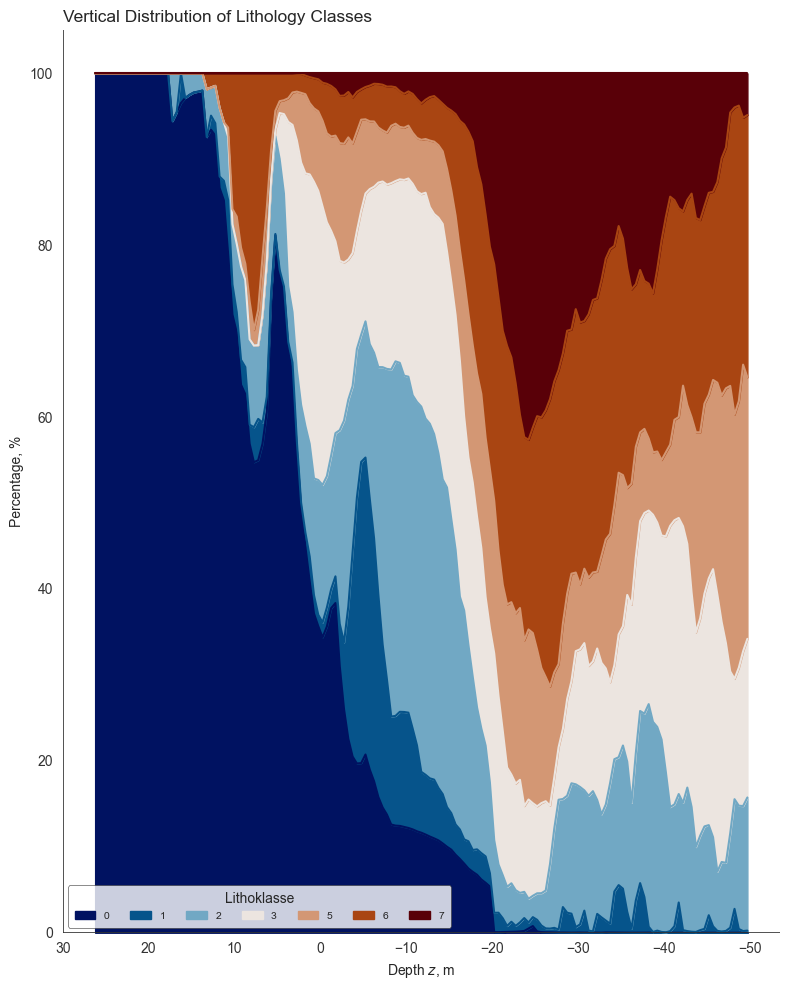

In [45]:
df_plot = depth_dist.sort_index()


axes_color = '#333333'
fontsize = 10

fig, ax = plt.subplots(figsize=(8, 10))
df_plot.plot.area(ax=ax, cmap=cm.vik)

plt.gca().invert_xaxis() 
leg = ax.legend(
    title="Lithoklasse", loc=0, ncols=8,
    edgecolor=axes_color, borderpad=.65, fontsize=fontsize*0.75
    )
leg.get_frame().set_linewidth(.5)
    
for spine in ax.spines.values():
    spine.set_visible(False)

ax.axhline(y=ax.get_ylim()[0], color=axes_color, linewidth=1.2, zorder=10)
ax.axvline(x=ax.get_xlim()[0], color=axes_color, linewidth=1.2, zorder=10)

ax.tick_params(axis='x', colors=axes_color)
ax.tick_params(axis='y', colors=axes_color)

ax.grid(False)
ax.set_xlabel("Depth $z$, m", fontsize=fontsize)
ax.set_ylabel("Percentage, %", fontsize=fontsize)
ax.set_title("Vertical Distribution of Lithology Classes", loc='left', fontsize=fontsize*1.25)

plt.tight_layout()

plt.show()

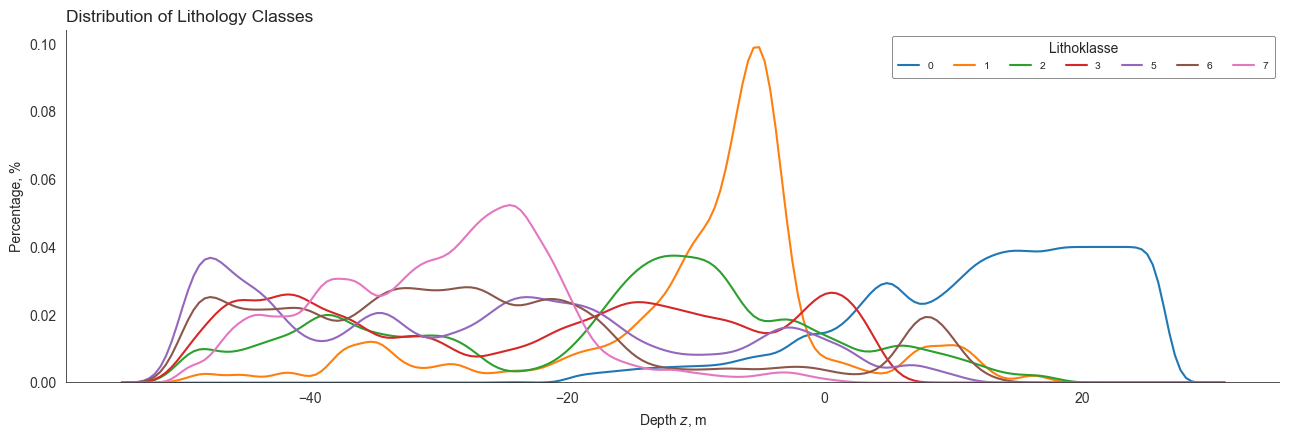

In [70]:
axes_color = '#333333'
fontsize = 10

fig, ax = plt.subplots(figsize=(13, 4.5))
for col in depth_dist.columns:
    sns.kdeplot(x=depth_dist.index, weights=depth_dist[col], bw_adjust=.2, label=col, ax=ax)

leg = ax.legend(
    title="Lithoklasse", loc=0, ncols=8,
    edgecolor=axes_color, borderpad=.65, fontsize=fontsize*0.75
    )
leg.get_frame().set_linewidth(.5)
    
for spine in ax.spines.values():
    spine.set_visible(False)

ax.axhline(y=ax.get_ylim()[0], color=axes_color, linewidth=1.2, zorder=10)
ax.axvline(x=ax.get_xlim()[0], color=axes_color, linewidth=1.2, zorder=10)

ax.tick_params(axis='x', colors=axes_color)
ax.tick_params(axis='y', colors=axes_color)

ax.grid(False)
ax.set_xlabel("Depth $z$, m", fontsize=fontsize)
ax.set_ylabel("Percentage, %", fontsize=fontsize)
ax.set_title("Distribution of Lithology Classes", loc='left', fontsize=fontsize*1.25)

plt.tight_layout()

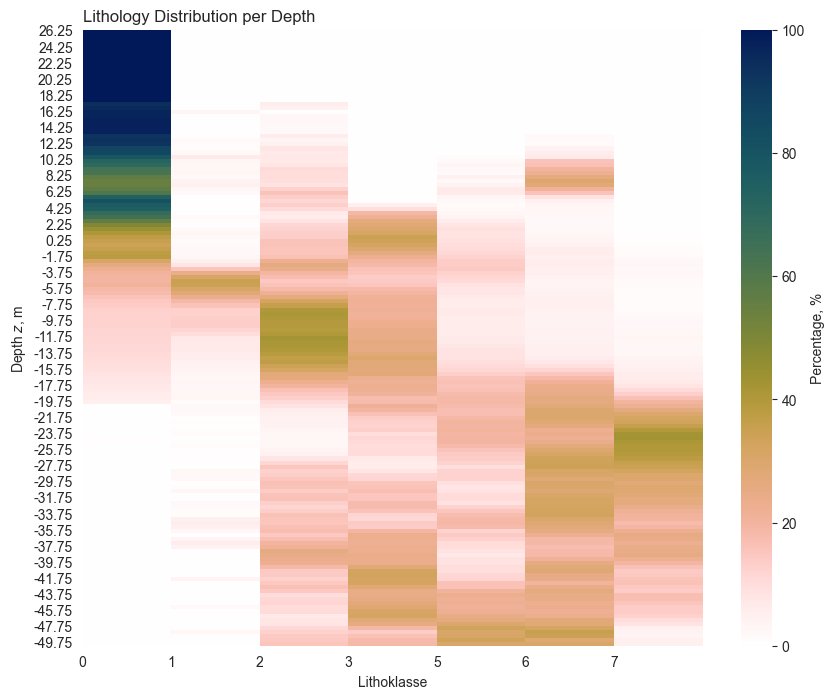

In [65]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(depth_dist, cmap=cm.batlowW_r, cbar=True, cbar_kws={'label': 'Percentage, %'}, ax=ax)

plt.xticks(
    ticks=arange(len(depth_dist.columns)),
    labels=depth_dist.columns
)

plt.gca().invert_yaxis() 
plt.xlabel("Lithoklasse")
plt.ylabel("Depth $z$, m")
plt.title("Lithology Distribution per Depth", loc='left')
plt.show()

# Data Vis 3D Projection

### Original Voxel

In [ ]:
fig = ft.plot_voxel(
    unique_points, elev=30, azim=45, 
    layer_label='layers',  dx=0.002, dy=0.002, 
    save_name='output/smoothed_dataset',
    save=False, display_plot=True, figsize=(18,6)
    )

if save:
    fig.savefig(f"output/original_voxel_around_{longitude}-{latitude}.png")

In [ ]:
dic_original_figs = dict()
for azim in linspace(0, 360, 12):
    dic_original_figs[azim] = ft.plot_voxel(
        unique_points, elev=30, azim=azim,
        save_name='output/original_dataset', 
        layer_label='layers',  dx=0.002, dy=0.002, 
        save=True, display_plot=False, figsize=(18,6)
        )

### Smoothing 

##### Gaussian or moving average smoothing along depth

In [ ]:
all_materials = list(set(l['lithoklasse_material'] for pt in unique_points for l in pt['layers']))
material_to_num = {m: i for i, m in enumerate(all_materials)}
num_to_material = {i: m for m, i in material_to_num.items()}

smoothed_points = []

# Kernel size: sigma in Gaussian filter controls smoothness
sigma = 2  # adjust; larger = smoother

for pt in unique_points:
    layers = sorted(pt['layers'], key=lambda l: l['z'])
    z_vals = array([l['z'] for l in layers])
    mat_nums = array([material_to_num[l['lithoklasse_material']] for l in layers])
    
    smoothed_nums = gaussian_filter1d(mat_nums.astype(float), sigma=sigma)
    
    smoothed_materials = [num_to_material[int(round(n))] for n in smoothed_nums]
    
    smoothed_layers = [
        {'z': z, 'lithoklasse_material': mat, 'lithoklasse_color': material_color_mapping[mat]} 
        for z, mat in zip(z_vals, smoothed_materials)
        ]
    
    smoothed_points.append({
        'lat': pt['lat'],
        'lon': pt['lon'],
        'layers_smoothed': smoothed_layers
    })


In [ ]:
fig = ft.plot_voxel(
    smoothed_points, elev=30, azim=45, 
    layer_label='layers_smoothed',  dx=0.002, dy=0.002, 
    save_name='output/smoothed_dataset',
    save=False, display_plot=True, figsize=(18,6)
    )

if save:
    fig.savefig(f"output/20251211_Gauss-smoothed_voxel_around_{longitude}-{latitude}.png")

In [ ]:
dic_smoothed_figs = dict()
for azim in linspace(0, 360, 12):
    dic_smoothed_figs[azim] = ft.plot_voxel(
        smoothed_points, layer_label='layers_smoothed', elev=30, azim=azim, save=True, 
        save_name='output/smoothed_dataset', display_plot=False, dx=0.002, dy=0.002, figsize=(18,6)
        )

##### Majority voting / clustering of adjacent same class layers

done for all data


z_start - z_end!!

In [ ]:
data_grouped = points_in_rotterdam.reset_index()

In [ ]:
data_grouped['group'] = (
    (data_grouped['lithoklasse'] != data_grouped['lithoklasse'].shift()) |
    (data_grouped['lon'] != data_grouped['lon'].shift()) |
    (data_grouped['lat'] != data_grouped['lat'].shift())
).cumsum()

data_grouped.head(7)

In [ ]:
likelihood_cols = [col for col in data_grouped.columns if col.startswith('kans_')]


In [ ]:
agg_dict = {
    'lon': lambda x: x.iloc[0] if x.nunique() == 1 else list(x.unique()),
    'lat': lambda x: x.iloc[0] if x.nunique() == 1 else list(x.unique()),

    'z': ['min', 'max'],

    'lithostrat': lambda x: x.iloc[0],
    'lithoklasse': lambda x: x.iloc[0],
}


In [ ]:
for col in likelihood_cols:
    agg_dict[col] = 'mean'

df_grouped = data_grouped.groupby('group').agg(agg_dict)
df_grouped.columns = [
    f'{c[0]}_{c[1]}' if isinstance(c, tuple) else c
    for c in df_grouped.columns
]

In [ ]:
df_grouped = df_grouped.rename(columns={
    'lon_<lambda>': 'lon',
    'lat_<lambda>': 'lat',
    'lithoklasse_<lambda>': 'lithoklasse',
    'lithostrat_<lambda>': 'lithostrat',
})
df_grouped = df_grouped.reset_index(drop=True)
df_grouped.head(10)

Verify averaging to add to 100%

In [ ]:
data_kans = data_grouped.filter(like='kans_').sum(axis=1)
data_kans

In [ ]:
data_kans.plot(lw=0, marker='o', figsize=(13, 3.5))

In [ ]:
df_grouped['lithoklasse_material'] = [map_lithoclasses[k] for k in df_grouped.lithoklasse]
df_grouped['lithoklasse_color'] = [material_color_mapping[c] for c in df_grouped['lithoklasse_material']]

In [ ]:
filtered = df_grouped[df_grouped['lon'].isin(points_around_input.lon.unique())]
filtered = filtered[filtered['lat'].isin(points_around_input.lat.unique())]
filtered

In [ ]:
profiles_grouped, unique_points_grouped = ft.get_unique_points(points_around_input=filtered)

In [ ]:
fig = ft.plot_voxel(
    unique_points_grouped, elev=30, azim=45, 
    layer_label='layers',  dx=0.002, dy=0.002, 
    save_name='output/smoothed_dataset',
    save=False, display_plot=True, figsize=(18,6)
    )

fig.savefig(f"output/20251211_Content-smoothed_voxel_around_{longitude}-{latitude}.png")

# Output as JSON

### Prepare for Output

In [ ]:
columns_kans = df_grouped.filter(like='kans_').columns
df_grouped[columns_kans] = df_grouped[columns_kans].round(4)

In [ ]:
df_grouped.rename(columns={'z_min': 'z_bottom', 'z_max': 'z_top'}, inplace=True)

In [ ]:
lithoclass_material = df_grouped['lithoklasse'].map(map_lithoclasses)
df_grouped['lithoclass_material'] = lithoclass_material

In [ ]:
selected_columns = [
    'lon', 'lat', 'z_top', 'z_bottom', 'lithoklasse', 'lithoclass_material', 
    'kans_1_veen_mean', 'kans_2_klei_mean', 'kans_3_kleiig_zand_mean', 
    'kans_4_vervallen_mean', 'kans_5_zand_fijn_mean', 'kans_6_zand_matig_grof_mean', 
    'kans_7_zand_grof_mean', 'kans_8_grind_mean', 'kans_9_schelpen_mean'
]

cropped = df_grouped.reset_index()[selected_columns]
cropped.rename(columns={
    'lithoklasse':'lithoklasse_id', 
    'lithoclass_material':'lithoklasse'
    }, inplace=True)

cropped

In [ ]:
profiled = cropped.groupby(['lon', 'lat']).apply(
    lambda g: sorted(g.to_dict(orient='records'), key=lambda d: d['z_top'], reverse=True)
).reset_index(name='data')

list_of_lists = profiled['data'].tolist()

### Export all data in one file

for all data points, describe the identified lithoclass (through mapping) and select likelihood of all material being present 

In [ ]:
base_name = f"B01-to-B09_lithoclass_materials_and_likelihood_geocoordinates"
name_file =  f"_Rotterdam_city_{datetime.now().date().isoformat()}.json"
file_path = dir_export + base_name + name_file

with open(file_path, 'w') as f:
    json.dump(list_of_lists, f)

print(f"stored {file_path}")

### Export in batches

In [ ]:
MAX_BYTES = 5 * 1024 * 1024  # 5 MB

batch = []
batch_size = 0
file_index = 1

output_dir = dir_export + f"json_5MB_chunks_{datetime.now().date().isoformat()}/"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
for sublist in list_of_lists:
    sublist_bytes = len(json.dumps(sublist, separators=(',', ':')).encode('utf-8'))

    if batch_size + sublist_bytes > MAX_BYTES and batch:
        file_name = os.path.join(output_dir, f"litho_batch_{file_index}.json")
        with open(file_name, 'w') as f:
            json.dump(batch, f, separators=(',', ':'))
        print(f"Stored {file_name} ({batch_size / 1024**2:.2f} MB)")

        file_index += 1
        batch = []
        batch_size = 0

    batch.append(sublist)
    batch_size += sublist_bytes

if batch:
    file_name = os.path.join(output_dir, f"litho_batch_{file_index}.json")
    with open(file_name, 'w') as f:
        json.dump(batch, f, separators=(',', ':'))
    print(f"Stored {file_name} ({batch_size / 1024**2:.2f} MB)")

# Read JSON

In [ ]:
output_dir = 'output/json_5MB_chunks_2025-12-04/'

In [ ]:
ls_files_for_read = [file for file in glob(output_dir + '*.json')]

In [ ]:
ls_df = []
for en, path in enumerate(ls_files_for_read):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        print(f"Reading file {en+1} from {len(ls_files_for_read)}...")

        dfs = []

        for f_sub in data:
            if isinstance(f_sub, list):
                if len(f_sub) > 0 and isinstance(f_sub[0], dict):
                    dfs.append(DataFrame(f_sub))
                else:
                    dfs.append(DataFrame({"value": f_sub}))
            
            elif isinstance(f_sub, dict):
                dfs.append(DataFrame([f_sub]))

            else:
                dfs.append(DataFrame({"value": [f_sub]}))

        file_df = concat(dfs, ignore_index=True)
        ls_df.append(file_df)


df_import = concat(ls_df)

In [ ]:
print(
    f"comparing shapes of datasets:"
    f"\n original dataset: {cropped.shape},"
    f"\n re-imported dataset: {df_import.shape} and"
    f"\n duplicated removed: {df_import.drop_duplicates().shape}")